# GBM Discussion

The data here is taken form the Data Hackathon3.x - http://datahack.analyticsvidhya.com/contest/data-hackathon-3x

## Import Libraries:

In [6]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, cross_val_score

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

## Load Data:

The data has gone through following pre-processing:
1. City variable dropped because of too many categories
2. DOB converted to Age | DOB dropped
3. EMI_Loan_Submitted_Missing created which is 1 if EMI_Loan_Submitted was missing else 0 | EMI_Loan_Submitted dropped
4. EmployerName dropped because of too many categories
5. Existing_EMI imputed with 0 (median) - 111 values were missing
6. Interest_Rate_Missing created which is 1 if Interest_Rate was missing else 0 | Interest_Rate dropped 
7. Lead_Creation_Date dropped because made little intuitive impact on outcome
8. Loan_Amount_Applied, Loan_Tenure_Applied imputed with missing
9. Loan_Amount_Submitted_Missing created which is 1 if Loan_Amount_Submitted was missing else 0 | Loan_Amount_Submitted dropped 
10. Loan_Tenure_Submitted_Missing created which is 1 if Loan_Tenure_Submitted was missing else 0 | Loan_Tenure_Submitted dropped 
11. LoggedIn, Salary_Account removed
12. Processing_Fee_Missing created which is 1 if Processing_Fee was missing else 0 | Processing_Fee dropped
13. Source - top 2 kept as is and all others combined into different category
14. Numerical and One-Hot-Coding performed

In [3]:
train = pd.read_csv('../Dataset/train_modified.csv')

In [39]:
test = pd.read_csv('../Dataset/test_modified.csv')

In [4]:
target='Disbursed'
IDcol = 'ID'

In [5]:
train['Disbursed'].value_counts()

0.0    85747
1.0     1273
Name: Disbursed, dtype: int64

## Define a function for modeling and cross-validation

This function will do the following:
1. fit the model
2. determine training accuracy
3. determine training AUC
4. determine testing AUC
5. perform CV is performCV is True
6. plot Feature Importance if printFeatureImportance is True

In [9]:
def modelfit(alg, dtrain, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'])
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, dtrain[predictors], dtrain['Disbursed'], cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
                
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')

## Baseline Model

Since here the criteria is AUC, simply predicting the most prominent class would give an AUC of 0.5 always. Another way of getting a baseline model is to use the algorithm without tuning, i.e. with default parameters.


Model Report
Accuracy : 0.9856
AUC Score (Train): 0.862264
CV Score : Mean - 0.8318589 | Std - 0.008756969 | Min - 0.820805 | Max - 0.8438558


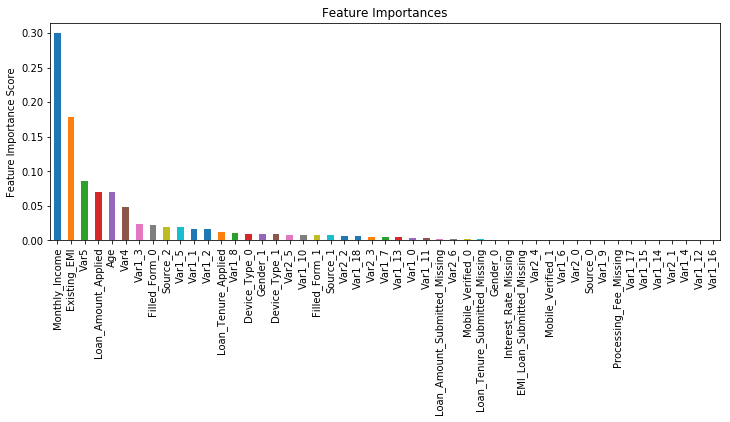

In [11]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, train, predictors)

## GBM Models:

There 2 types of parameters here:
1. Tree-specific parameters
  * min_samples_split
  * min_samples_leaf
  * max_depth
  * min_leaf_nodes
  * max_features
  * loss function
2. Boosting specific paramters
  * n_estimators
  * learning_rate
  * subsample

## Approach for tackling the problem

1. Decide a relatively higher value for learning rate and tune the number of estimators requried for that.
2. Tune the tree specific parameters for that learning rate
3. Tune subsample
4. Lower learning rate as much as possible computationally and increase the number of estimators accordingly.

## Step 1- Find the number of estimators for a high learning rate

We will use the following benchmarks for parameters:
1. min_samples_split = 500 : ~0.5-1% of total values. Since this is imbalanced class problem, we'll take small value
2. min_samples_leaf = 50 : Just using for preventing overfitting. will be tuned later.
3. max_depth = 8 : since high number of observations and predictors, choose relatively high value
4. max_features = 'sqrt' : general thumbrule to start with
5. subsample = 0.8 : typically used value (will be tuned later)

0.1 is assumed to be a good learning rate to start with. Let's try to find the optimum number of estimators requried for this.

In [17]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]
param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,
                                  min_samples_leaf=50,max_depth=8,max_features='sqrt', subsample=0.8,random_state=10), 
                       param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5, return_train_score=True)
gsearch1.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=50, min_samples_split=500,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'n_estimators': range(20, 81, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [18]:
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([ 2.87803974,  4.14291229,  4.82204566,  5.79294915,  6.70756588,
          7.79204507,  7.83567257]),
  'mean_score_time': array([ 0.03652945,  0.0458179 ,  0.04808993,  0.05337095,  0.06103668,
          0.07051568,  0.06422248]),
  'mean_test_score': array([ 0.83337449,  0.83697031,  0.83832436,  0.83867433,  0.83938752,
          0.83891432,  0.83806872]),
  'mean_train_score': array([ 0.88219203,  0.88959112,  0.89534287,  0.90140879,  0.90649064,
          0.91084815,  0.9147638 ]),
  'param_n_estimators': masked_array(data = [20 30 40 50 60 70 80],
               mask = [False False False False False False False],
         fill_value = ?),
  'params': [{'n_estimators': 20},
   {'n_estimators': 30},
   {'n_estimators': 40},
   {'n_estimators': 50},
   {'n_estimators': 60},
   {'n_estimators': 70},
   {'n_estimators': 80}],
  'rank_test_score': array([7, 6, 4, 3, 1, 2, 5], dtype=int32),
  'split0_test_score': array([ 0.81912514,  0.82194546,  0.82289556,  

So we got 60 as the optimal estimators for the 0.1 learning rate. Note that 60 is a reasonable value and can be used as it is. But it might not be the same in all cases. Other situations:
1. If the value is around 20, you might want to try lowering the learning rate to 0.05 and re-run grid search
2. If the values are too high ~100, tuning the other parameters will take long time and you can try a higher learning rate

## Step 2- Tune tree-specific parameters
Now, lets move onto tuning the tree parameters. We will do this in 2 stages:
1. Tune max_depth and num_samples_split
2. Tune min_samples_leaf
3. Tune max_features

In [19]:
#Grid seach on subsample and max_features
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,
                                                max_features='sqrt', subsample=0.8, random_state=10), 
                       param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5, return_train_score=True)
gsearch2.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=60,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_depth': range(5, 16, 2), 'min_samples_split': range(200, 1001, 200)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [20]:
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

({'mean_fit_time': array([  4.17309747,   4.05235906,   4.00676079,   3.93452144,
           3.91417284,   6.21404896,   5.86083097,   5.64709077,
           5.6651588 ,   5.45806942,   8.57559037,   7.88834043,
           7.46075416,   7.13113842,   7.54069676,  11.95174413,
          10.0573442 ,   9.59228282,   9.35877252,   8.41399655,
          14.6366787 ,  12.83812532,  10.88219619,  10.13719373,
           9.57784433,  16.75038128,  13.69857669,  12.36252446,
          11.40399556,   9.78564844]),
  'mean_score_time': array([ 0.05232134,  0.05321651,  0.05343661,  0.05173521,  0.05340157,
          0.06384373,  0.05666566,  0.06368847,  0.06007214,  0.05968513,
          0.06458883,  0.06533475,  0.06245852,  0.07007842,  0.06289949,
          0.07872672,  0.08283811,  0.07837305,  0.07771544,  0.07479954,
          0.09200473,  0.08383369,  0.07898898,  0.08015189,  0.08000507,
          0.10111609,  0.09273129,  0.0861053 ,  0.08350945,  0.07080154]),
  'mean_test_score': arr

Since we reached the maximum of min_sales_split, we should check higher values as well. Also, we can tune min_samples_leaf with it now as max_depth is fixed. One might argue that max depth might change for higher value but if you observe the output closely, a max_depth of 9 had a better model for most of cases.
So lets perform a grid search on them:

In [23]:
#Grid seach on subsample and max_features
param_test3 = {'min_samples_split':range(1000,2100,200), 'min_samples_leaf':range(30,71,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=9,
                                                    max_features='sqrt', subsample=0.8, random_state=10), 
                       param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=9,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=60,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'min_samples_split': range(1000, 2100, 200), 'min_samples_leaf': range(30, 71, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [24]:
gsearch3.best_params_, gsearch3.best_score_

({'min_samples_leaf': 60, 'min_samples_split': 1200}, 0.83975976288429499)


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.896453
CV Score : Mean - 0.8397598 | Std - 0.009936017 | Min - 0.8255474 | Max - 0.8527672


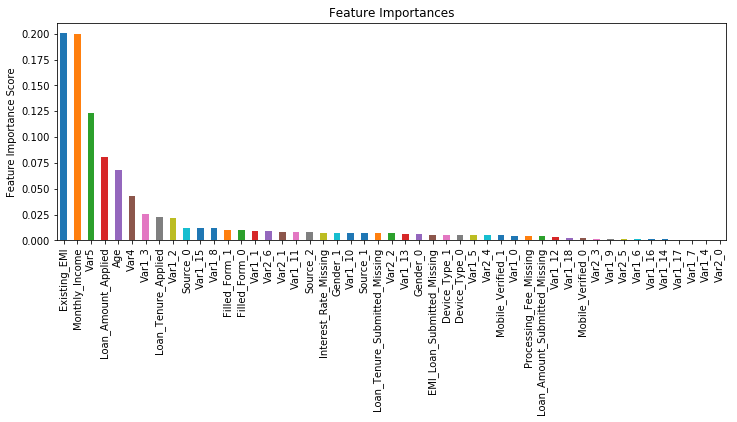

In [25]:
modelfit(gsearch3.best_estimator_, train, predictors)

Tune max_features:

In [26]:
#Grid seach on subsample and max_features
param_test4 = {'max_features':range(7,20,2)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=9, 
                            min_samples_split=1200, min_samples_leaf=60, subsample=0.8, random_state=10),
                       param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=9,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=60, min_samples_split=1200,
              min_weight_fraction_leaf=0.0, n_estimators=60,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_features': range(7, 20, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [27]:
gsearch4.best_params_, gsearch4.best_score_

({'max_features': 7}, 0.83975976288429499)

In [30]:
#Grid seach on subsample and max_features
param_test5 = {'max_features':range(1,8)}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=9, 
                            min_samples_split=1200, min_samples_leaf=60, subsample=0.8, random_state=10),
                       param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch5.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=9,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=60, min_samples_split=1200,
              min_weight_fraction_leaf=0.0, n_estimators=60,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_features': range(1, 8)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='roc_auc', verbose=0)

In [31]:
gsearch5.best_params_, gsearch5.best_score_

({'max_features': 7}, 0.83975976288429499)

## Step3- Tune Subsample and Lower Learning Rate

In [32]:
#Grid seach on subsample and max_features
param_test6 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch6 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=9, 
                            min_samples_split=1200, min_samples_leaf=60, subsample=0.8, random_state=10, max_features=7),
                       param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=9,
              max_features=7, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=60, min_samples_split=1200,
              min_weight_fraction_leaf=0.0, n_estimators=60,
              presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [33]:
gsearch6.best_params_, gsearch6.best_score_

({'subsample': 0.85}, 0.84085800832187396)

With all tuned lets try reducing the learning rate and proportionally increasing the number of estimators to get more robust results:


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.897619
CV Score : Mean - 0.8391332 | Std - 0.009437997 | Min - 0.8271238 | Max - 0.8511221


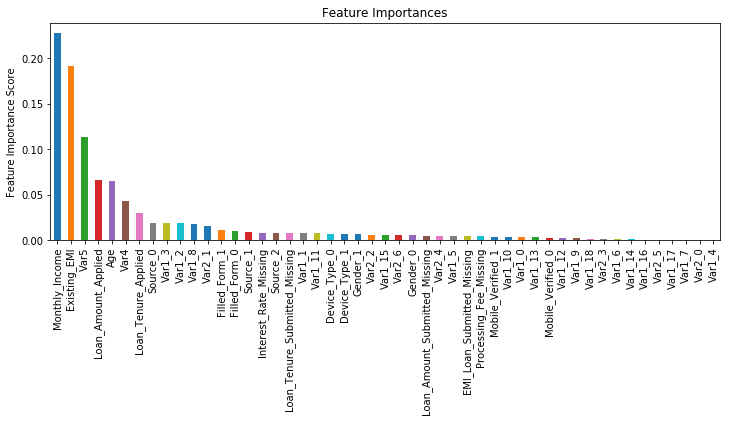

In [34]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.05, n_estimators=120,max_depth=9, min_samples_split=1200, 
                                         min_samples_leaf=60, subsample=0.85, random_state=10, max_features=7)
modelfit(gbm_tuned_1, train, predictors)

1/10th learning rate


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.899962
CV Score : Mean - 0.8407913 | Std - 0.01011421 | Min - 0.8255379 | Max - 0.8522251


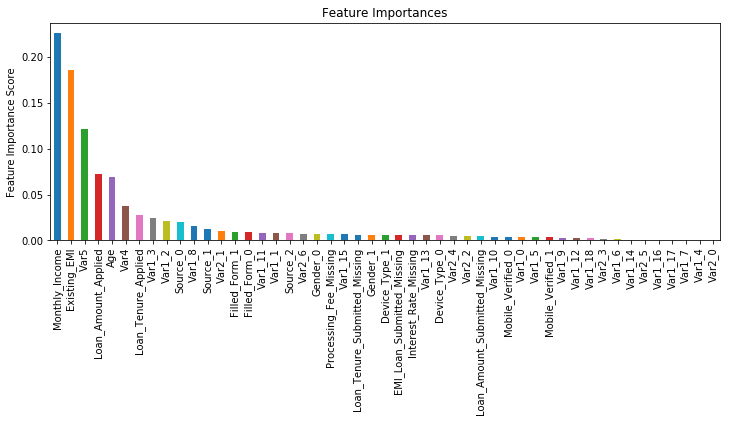

In [36]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm_tuned_2 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=600,max_depth=9, min_samples_split=1200, 
                                         min_samples_leaf=60, subsample=0.85, random_state=10, max_features=7)
modelfit(gbm_tuned_2, train, predictors)

1/50th learning rate


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.900713


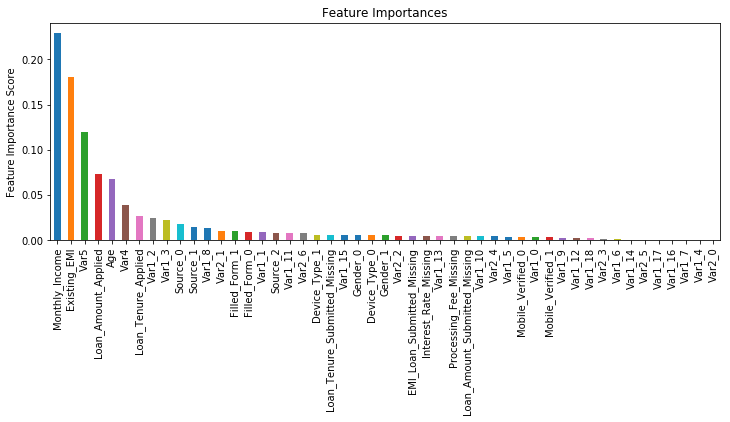

In [37]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm_tuned_3 = GradientBoostingClassifier(learning_rate=0.005, n_estimators=1200,max_depth=9, min_samples_split=1200, 
                                         min_samples_leaf=60, subsample=0.85, random_state=10, max_features=7,
                                         warm_start=True)
modelfit(gbm_tuned_3, train, predictors, performCV=False)


Model Report
Accuracy : 0.9854
AUC Score (Train): 0.906303


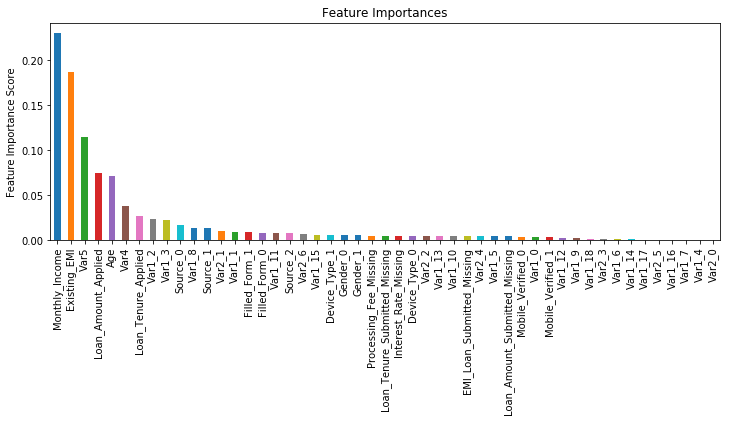

In [38]:
#Choose all predictors except target & IDcols
predictors = [x for x in train.columns if x not in [target, IDcol]]
gbm_tuned_4 = GradientBoostingClassifier(learning_rate=0.005, n_estimators=1500,max_depth=9, min_samples_split=1200, 
                                         min_samples_leaf=60, subsample=0.85, random_state=10, max_features=7,
                                         warm_start=True)
modelfit(gbm_tuned_4, train, predictors, performCV=False)